# **Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline**

In this workbook, we implement 3 basic neural network architectures introduced in the paper [1]: an MLP, a Fully Convolutional Network and a Residual Network.

In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adadelta, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from keras.layers import Input, Layer, Dropout, BatchNormalization, Conv1D, MaxPool1D, ReLU, Dense, Flatten, GlobalMaxPool2D, GlobalAveragePooling1D, GlobalMaxPooling1D

In [2]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/benchmarks')

%run ../sys_configs.ipynb

Mounted at /content/drive


In [3]:
with open('../data/1s_train.npy', 'rb') as f:
    x1s_train = np.load(f)
    y1s_train = np.load(f)
sz, dim = x1s_train.shape[1:]

with open('../data/1s_val.npy', 'rb') as f:
    x1s_val = np.load(f)
    y1s_val = np.load(f)

In [4]:
# Convert the labels to tensors
train_labels_tf = tf.one_hot(y1s_train, 31, dtype=tf.int32)
val_labels_tf = tf.one_hot(y1s_val, 31, dtype=tf.int32)

In [5]:
# Convert the dataset to tensors
train_data_tf = tf.convert_to_tensor(x1s_train, dtype=tf.float32)
val_data_tf = tf.convert_to_tensor(x1s_val, dtype=tf.float32)

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data_tf, train_labels_tf))
val_ds = tf.data.Dataset.from_tensor_slices((val_data_tf, val_labels_tf))

In [7]:
train_ds = train_ds.shuffle(500)

train_ds = train_ds.padded_batch(16)
val_ds = val_ds.padded_batch(16)

Each architecture considered is evaluated using the Mean Per-Class Error (MPCE) to evaluate its average classification performance across classes.

Suppose there are $K$ classes and the $k$th class has $c_{k}$ elements and the number which are incorrectly predicted is $e_{k}$.

The MPCE is calculated by averaging the expected error rate for each class, and therefore treats every class with equal importance.

The paper introduces the idea of a paired T-test on the PCE values which identifies whether the MPCE differences are significant across different classes.

<div style="text-align: center;">
$$
\begin{aligned}
PCE_{k} & = \frac{e_{k}}{c_{k}} \\
MPCE_{k} & = \frac{1}{K}\Sigma_{k=1}^{K}PCE_{k}
\end{aligned}
$$
</div>

In [8]:
class MPCE(tf.keras.metrics.Metric):
    def __init__(self, name='MPCE', **kwargs):
        super(MPCE, self).__init__(name=name, **kwargs)
        self.total_error = self.add_weight(name='total_error', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Get the predicted class by taking the argmax
        y_pred_classes = tf.cast(tf.argmax(y_pred, axis=-1), dtype = tf.int32)
        y_true_classes = tf.cast(tf.argmax(y_true, axis=-1), dtype = tf.int32)

        # Initialize variables to store the error rates for each class
        unique_classes = tf.unique(y_true_classes)[0]
        num_classes = len(tf.unique(y_true_classes)[0])

        total_error = 0.0
        neq = tf.not_equal(y_pred_classes, y_true_classes)
        for c in unique_classes:
            # Get the mask for the current class
            mask = tf.equal(y_true_classes, c)

            # Count the number of samples of the current class
            class_count = tf.reduce_sum(tf.cast(mask, tf.float32))

            # Compute the error rate for the current class
            neq_class = neq & mask
            class_errors = tf.reduce_sum(tf.cast(neq_class, tf.float32))

            # The below correction is necessary if a class does not appear in the validation/test set (all classes appear in the train set)
            class_error_rate = class_errors / (class_count + tf.keras.backend.epsilon())
            total_error += class_error_rate

        # Compute the mean error across all classes
        mean_error = total_error / tf.cast(num_classes, tf.float32)

        self.total_error.assign_add(mean_error)
        self.count.assign_add(1.0)

    def result(self):
        return self.total_error / self.count

    def reset_state(self):
        self.total_error.assign(0.0)
        self.count.assign(0.0)


In [9]:
C = len(set(y1s_train)) # Number of classes

<figure>
    <img src="../documentation/strong_baseline.png" alt="Alt text" width="500" />
    <figcaption style="text-align: center;">Figure 1: Diagram of the baseline methods</figcaption>
</figure>

## **Multilayer Perceptron**

In the MLP baseline, there are 3 fully connected layers each with 500 neurons with the ReLU activation function. Dropout regularisation is applied at each layer, which improves the network's ability to generalise. The MLP is trained with the Adadelta optimiser, learning rate 0.1, $\rho$ =  0.95 and $\epsilon$ = $10^{-8}$ in line with the paper.

In [10]:
def mlp_model(shape):
    input_layer = Input(shape=shape)

    # The input time series is multi-dimensional so that the matrix is N x T x D, but dense layers work with 2 dimenensions
    layer = tf.keras.layers.TimeDistributed(Dense(units=1))(input_layer)
    layer = tf.squeeze(layer, axis=-1)

    # Retain the rest of the architecture
    layer = Dropout(0.1)(layer)
    layer = Dense(500, activation=None, kernel_regularizer=regularizers.L1(l1=0.05))(layer)
    layer = ReLU()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(500, kernel_regularizer=regularizers.L1(l1=0.05), activation=None)(layer)
    layer = ReLU()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(500, kernel_regularizer=regularizers.L1(l1=0.05), activation=None)(layer)
    layer = ReLU()(layer)
    layer = Dropout(0.3)(layer)
    output_layer = Dense(C, activation='softmax')(layer)

    return Model(inputs=input_layer, outputs=output_layer)


In [11]:
mlp_model = mlp_model(shape = (sz, dim))
mlp_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 6)]          0         
                                                                 
 time_distributed (TimeDist  (None, 500, 1)            7         
 ributed)                                                        
                                                                 
 tf.compat.v1.squeeze (TFOp  (None, 500)               0         
 Lambda)                                                         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 re_lu (ReLU)                (None, 500)               0     

In [12]:
mlp_model.compile(optimizer=Adadelta(learning_rate=0.1, rho=0.95, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy', MPCE()])
history = mlp_model.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25
190/190 [==============================] - 5s 10ms/step - loss: 1301.5569 - accuracy: 0.0382 - MPCE: 0.9593 - val_loss: 1142.5612 - val_accuracy: 0.0524 - val_MPCE: 0.9499
Epoch 2/25
190/190 [==============================] - 2s 9ms/step - loss: 987.8369 - accuracy: 0.0554 - MPCE: 0.9462 - val_loss: 832.3495 - val_accuracy: 0.0595 - val_MPCE: 0.9451
Epoch 3/25
190/190 [==============================] - 2s 11ms/step - loss: 687.1348 - accuracy: 0.0544 - MPCE: 0.9502 - val_loss: 544.8162 - val_accuracy: 0.0665 - val_MPCE: 0.9432
Epoch 4/25
190/190 [==============================] - 3s 15ms/step - loss: 419.1894 - accuracy: 0.0597 - MPCE: 0.9444 - val_loss: 300.6794 - val_accuracy: 0.0615 - val_MPCE: 0.9482
Epoch 5/25
190/190 [==============================] - 2s 11ms/step - loss: 205.9500 - accuracy: 0.0719 - MPCE: 0.9310 - val_loss: 122.8272 - val_accuracy: 0.1028 - val_MPCE: 0.9149
Epoch 6/25
190/190 [==============================] - 2s 9ms/step - loss: 70.3770 - accuracy: 

In [20]:
mlp_model.save('../models/mlp_model/mlp_model.h5')
with open('../models/mlp_model/train_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [10]:
# Load the model
custom_objects = {'MPCE': MPCE}
mlp_model = load_model('../models/mlp_model/mlp_model.h5', custom_objects=custom_objects)

# Load the training history
with open('../models/mlp_model/train_history.pkl', 'rb') as f:
    history = pickle.load(f)

In [23]:
# Get the predictions on the validation dataset
mlp_predictions = mlp_model.predict(val_data_tf)

# Calculate the MPCE custom loss metric that the paper uses on the validation data
mlp_MPCE = MPCE()
mlp_MPCE.update_state(val_labels_tf, mlp_predictions)
print('Manual Mean Per-Class Error:', mlp_MPCE.result().numpy())
print('Keras Mean Per-Class Error:', history['val_MPCE'][-1])

31/31 [==============================] - 0s 6ms/step
Manual Mean Per-Class Error: 0.9677419
Keras Mean Per-Class Error: 0.953566312789917


In [26]:
mlp_results = mlp_model.evaluate(val_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}\nValidation MPCE: {}".format(*mlp_results))

62/62 [==============================] - 1s 8ms/step - loss: 6.3379 - accuracy: 0.0554 - MPCE: 0.9536
Validation Loss: 6.3379292488098145
Validation Accuracy: 0.055443547666072845
Validation MPCE: 0.953566312789917


## **Fully Convolutional Neural Network**

FCNs can be trained pixel-to-pixel for semantic segmentation annotation tasks, in line with the paper. The main idea behind FCNs is that convolutional layers are followed by batch normalisation, then by the ReLU activation function. The kernels used in the convolutions are 1D and they are non-striding. The penultimate step in the network is global max pooling; this requires 0 new weight parameters. This is the step which, more than any other, is the source of the network's name, as it is normal to first flatten the condensed image and then apply a fully connected layer. The final step is a classification layer.



In [14]:
def fcn_model(shape):
    input_layer = Input(shape=shape)

    # The input time series is multi-dimensional so that the matrix is N x T x D. The Con1D layers preserve the time dimension).
    layer = Conv1D(filters=128, kernel_size=8, padding="same")(input_layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)

    layer = Conv1D(filters=256, kernel_size=5, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)

    layer = Conv1D(filters=128, kernel_size=3, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)

    layer = GlobalAveragePooling1D()(layer)
    output_layer = Dense(C, activation="softmax")(layer)

    return Model(inputs=input_layer, outputs=output_layer)

In [15]:
fcn_model = fcn_model(shape = (sz, dim))
fcn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 500, 128)          6272      
                                                                 
 batch_normalization (Batch  (None, 500, 128)          512       
 Normalization)                                                  
                                                                 
 re_lu_3 (ReLU)              (None, 500, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 256)          164096    
                                                                 
 batch_normalization_1 (Bat  (None, 500, 256)          1024      
 chNormalization)                                          

In [16]:
fcn_model.compile(optimizer=Adam(learning_rate=10e-2, beta_1=0.95, beta_2 = 0.99, epsilon=1e-7), loss='categorical_crossentropy', metrics=['accuracy', MPCE()])
history2 = fcn_model.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25
190/190 [==============================] - 9s 16ms/step - loss: 2.1304 - accuracy: 0.3353 - MPCE: 0.6647 - val_loss: 9.6761 - val_accuracy: 0.2621 - val_MPCE: 0.7635
Epoch 2/25
190/190 [==============================] - 3s 18ms/step - loss: 1.2509 - accuracy: 0.5394 - MPCE: 0.4585 - val_loss: 2.8382 - val_accuracy: 0.4577 - val_MPCE: 0.5508
Epoch 3/25
190/190 [==============================] - 3s 16ms/step - loss: 1.0547 - accuracy: 0.6123 - MPCE: 0.3850 - val_loss: 3.5799 - val_accuracy: 0.4335 - val_MPCE: 0.5845
Epoch 4/25
190/190 [==============================] - 3s 14ms/step - loss: 0.9029 - accuracy: 0.6591 - MPCE: 0.3380 - val_loss: 2.1485 - val_accuracy: 0.5413 - val_MPCE: 0.4655
Epoch 5/25
190/190 [==============================] - 4s 19ms/step - loss: 0.8373 - accuracy: 0.6812 - MPCE: 0.3166 - val_loss: 2.6489 - val_accuracy: 0.5413 - val_MPCE: 0.4675
Epoch 6/25
190/190 [==============================] - 3s 14ms/step - loss: 0.7827 - accuracy: 0.7201 - MPCE: 0.2772

In [21]:
fcn_model.save('../models/fcn_model/fcn_model.h5')
with open('../models/fcn_model/train_history.pkl', 'wb') as f:
    pickle.dump(history2.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Load the model
custom_objects = {'MPCE': MPCE}
fcn_model = load_model('../models/fcn_model/fcn_model.h5', custom_objects=custom_objects)

# Load the training history
with open('../models/fcn_model/train_history.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [28]:
# Get the predictions on the validation dataset
fcn_predictions = fcn_model.predict(val_data_tf)

# Calculate the MPCE custom loss metric that the paper uses on the validation data
fcn_MPCE = MPCE()
fcn_MPCE.update_state(val_labels_tf, fcn_predictions)
print('Manual Mean Per-Class Error:', fcn_MPCE.result().numpy())
print('Keras Mean Per-Class Error:', history2['val_MPCE'][-1])

31/31 [==============================] - 8s 255ms/step
Manual Mean Per-Class Error: 0.32617262
Keras Mean Per-Class Error: 0.3369916081428528


In [29]:
fcn_results = fcn_model.evaluate(val_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}\nValidation MPCE: {}".format(*fcn_results))

62/62 [==============================] - 7s 106ms/step - loss: 2.1252 - accuracy: 0.6704 - MPCE: 0.3370
Validation Loss: 2.125164747238159
Validation Accuracy: 0.6703628897666931
Validation MPCE: 0.3369916081428528


In [37]:
# Manually calculate the predicted class distribution
fcn_val_predictions = fcn_model.predict(val_data_tf)

# Find the class with the highest prediction value
fcn_val_predictions_class = tf.argmax(fcn_val_predictions, axis = 1)
fcn_val_labels_class = tf.argmax(val_labels_tf, axis = 1)

matches = tf.equal(fcn_val_predictions_class, fcn_val_labels_class)
manual_accuracy = tf.reduce_sum(tf.cast(matches, tf.int32))/len(fcn_val_labels_class)
print("Manual Accuracy: {}".format(manual_accuracy.numpy()))

31/31 [==============================] - 7s 227ms/step
Manual Accuracy: 0.6703629032258065


## **ResNet**

The idea behind ResNets is to divide a convolutional network into blocks. Within each block, there is a *shortcut* connection that enables the gradient to flow directly from the block start layer.

A single block is defined from the entire network given in the Fully Connected Network model introduced earlier, and the ResNet stacks 3 such residual blocks.

In [9]:
class ResidualBlock(Layer):

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.batch_norm_1 = BatchNormalization()
        self.batch_norm_2 = BatchNormalization()
        self.batch_norm_3 = BatchNormalization()

        self.relu_1 = ReLU()
        self.relu_2 = ReLU()
        self.relu_3 = ReLU()

        self.conv_1 = Conv1D(self.units, kernel_size=8, padding="same")
        self.conv_2 = Conv1D(self.units, kernel_size=5, padding="same")
        self.conv_3 = Conv1D(input_shape[-1], kernel_size=3, padding="same") # Last dimension of the input shape must match with last dimension of output shape

    def call(self, input):
        x = self.conv_1(input)
        x = self.batch_norm_1(x)
        x = self.relu_1(x)

        x = self.conv_2(x)
        x = self.batch_norm_2(x)
        x = self.relu_2(x)

        x = self.conv_3(x)
        x = self.batch_norm_3(x)
        x = self.relu_3(x)

        output = x + input
        return output

In [11]:
def resnet_model(shape):
    input_layer = Input(shape=shape)

    # The input time series is multi-dimensional so that the matrix is N x T x D. The Con1D layers preserve the time dimension).
    layer = ResidualBlock(64, name='block1')(input_layer)
    layer = ResidualBlock(128, name='block2')(layer)
    layer = ResidualBlock(128, name='block3')(layer)

    layer = GlobalMaxPooling1D()(layer)
    output_layer = Dense(C, activation="softmax")(layer)

    return Model(inputs=input_layer, outputs=output_layer)

In [12]:
resnet_model = resnet_model(shape = (sz, dim))
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 6)]          0         
                                                                 
 block1 (ResidualBlock)      (None, 500, 6)            25374     
                                                                 
 block2 (ResidualBlock)      (None, 500, 6)            91678     
                                                                 
 block3 (ResidualBlock)      (None, 500, 6)            91678     
                                                                 
 global_max_pooling1d (Glob  (None, 6)                 0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 31)                217       
                                                             

In [13]:
# We use early stopping as the ResNet is a high parameter network, so requires many epochs to train.
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [14]:
resnet_model.compile(optimizer=Adam(learning_rate=10e-2, beta_1=0.95, beta_2 = 0.99, epsilon=1e-7), loss='categorical_crossentropy', metrics=['accuracy', MPCE()])
history3 = resnet_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[earlystopping])

Epoch 1/50
190/190 [==============================] - 15s 22ms/step - loss: 2.4710 - accuracy: 0.2984 - MPCE: 0.7055 - val_loss: 1.8043 - val_accuracy: 0.3488 - val_MPCE: 0.6437
Epoch 2/50
190/190 [==============================] - 3s 16ms/step - loss: 1.7785 - accuracy: 0.4191 - MPCE: 0.5810 - val_loss: 1.7930 - val_accuracy: 0.3216 - val_MPCE: 0.6618
Epoch 3/50
190/190 [==============================] - 3s 15ms/step - loss: 1.6432 - accuracy: 0.4543 - MPCE: 0.5428 - val_loss: 1.8941 - val_accuracy: 0.4002 - val_MPCE: 0.5858
Epoch 4/50
190/190 [==============================] - 3s 15ms/step - loss: 1.6556 - accuracy: 0.4613 - MPCE: 0.5368 - val_loss: 1.6866 - val_accuracy: 0.4425 - val_MPCE: 0.5387
Epoch 5/50
190/190 [==============================] - 3s 15ms/step - loss: 1.6247 - accuracy: 0.4764 - MPCE: 0.5254 - val_loss: 1.6020 - val_accuracy: 0.4183 - val_MPCE: 0.5724
Epoch 6/50
190/190 [==============================] - 3s 16ms/step - loss: 1.5904 - accuracy: 0.4880 - MPCE: 0.509

In [15]:
resnet_model.save('../models/resnet_model/resnet_model.h5')
with open('../models/resnet_model/train_history.pkl', 'wb') as f:
    pickle.dump(history3.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Load the model
custom_objects = {'MPCE': MPCE, 'ResidualBlock': ResidualBlock}
resnet_model = load_model('../models/resnet_model/resnet_model.h5', custom_objects=custom_objects)

# Load the training history
with open('../models/resnet_model/train_history.pkl', 'rb') as f:
    history3 = pickle.load(f)

In [18]:
resnet_results = resnet_model.evaluate(val_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}\nValidation MPCE: {}".format(*resnet_results))

62/62 [==============================] - 1s 5ms/step - loss: 2.0326 - accuracy: 0.3982 - MPCE: 0.5961
Validation Loss: 2.0325920581817627
Validation Accuracy: 0.39818549156188965
Validation MPCE: 0.5960676670074463


In [19]:
# Manually calculate the predicted class distribution
resnet_val_predictions = resnet_model.predict(val_data_tf)

# Find the class with the highest prediction value
resnet_val_predictions_class = tf.argmax(resnet_val_predictions, axis = 1)
resnet_val_labels_class = tf.argmax(val_labels_tf, axis = 1)

matches = tf.equal(resnet_val_predictions_class, resnet_val_labels_class)
manual_accuracy = tf.reduce_sum(tf.cast(matches, tf.int32))/len(resnet_val_labels_class)
print("Manual Accuracy: {}".format(manual_accuracy.numpy()))

31/31 [==============================] - 1s 2ms/step
Manual Accuracy: 0.39818548387096775


## **Plot epochs vs MPCE for each model**

We conclude our analysis of the methods in this paper with plots of the MPCE for each model.

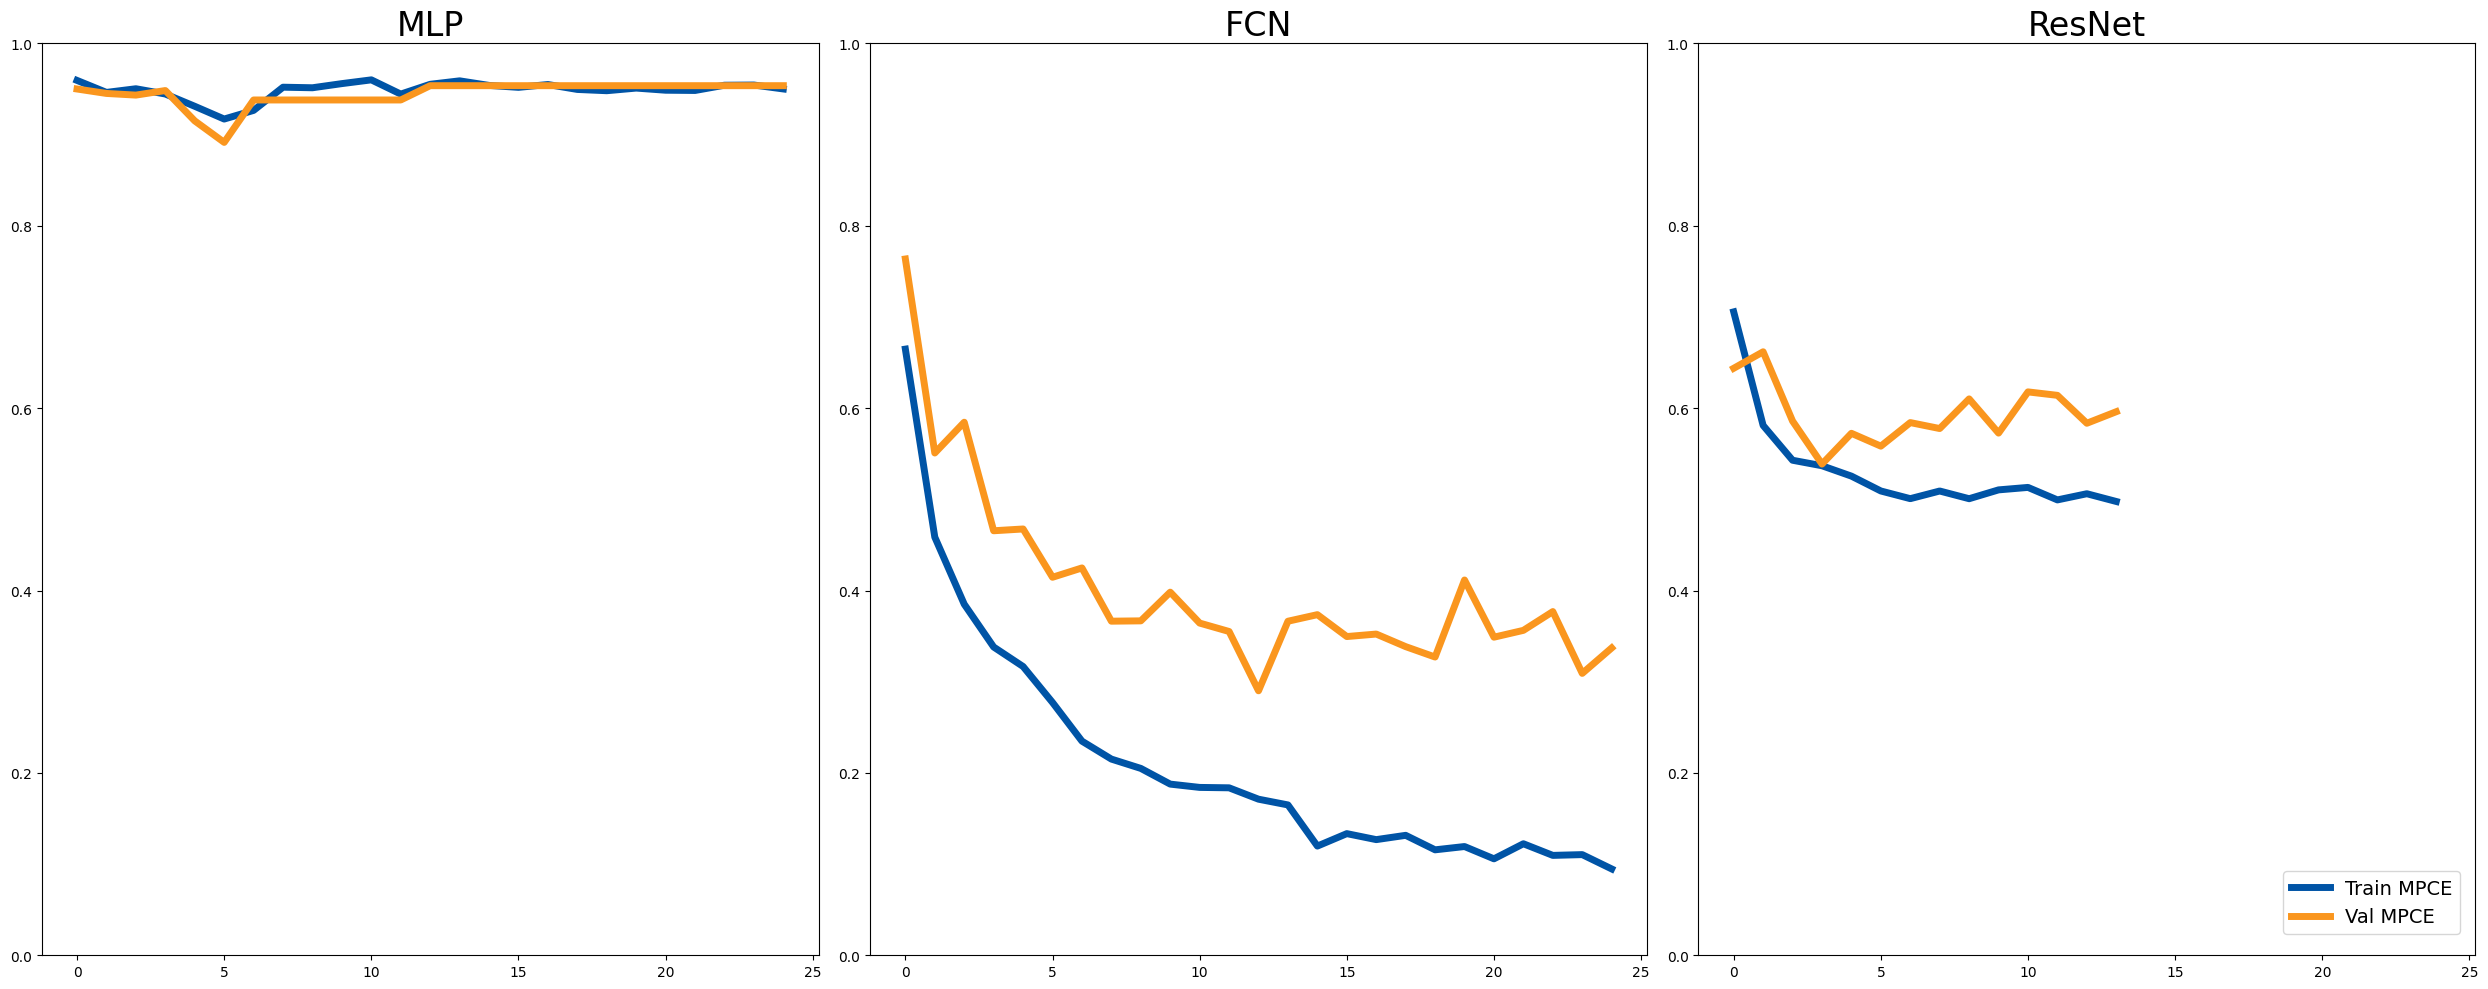

In [34]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, figsize=(25,10))
fig.subplots_adjust(hspace=0.0, wspace=0.3)

axes[0].plot(history['MPCE'], color = scale_rgb(COLOURS.get("accent-blue-dark-3")), linewidth=5, markersize=50, label='Train MPCE')
axes[0].plot(history['val_MPCE'], color = scale_rgb(COLOURS.get("accent-orange")), linewidth=5, markersize=50, label='Val MPCE')
axes[0].set_title("MLP", fontsize = 24)
axes[0].set_ylim([0, 1])

axes[1].plot(history2['MPCE'], color = scale_rgb(COLOURS.get("accent-blue-dark-3")), linewidth=5, markersize=50, label='Train MPCE')
axes[1].plot(history2['val_MPCE'], color = scale_rgb(COLOURS.get("accent-orange")), linewidth=5, markersize=50, label='Val MPCE')
axes[1].set_title("FCN", fontsize = 24)
axes[1].set_ylim([0, 1])

axes[2].plot(history3['MPCE'], color = scale_rgb(COLOURS.get("accent-blue-dark-3")), linewidth=5, markersize=50, label='Train MPCE')
axes[2].plot(history3['val_MPCE'], color = scale_rgb(COLOURS.get("accent-orange")), linewidth=5, markersize=50, label='Val MPCE')
axes[2].set_title("ResNet", fontsize = 24)
axes[2].set_ylim([0, 1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.99, 0.05), fontsize=14)

plt.tight_layout()
plt.show()

The FCN network appears to have the strongest potential for learning the true underlying function. This may be because of the weight sharing inherent in the convolutional filters. This is also shared with the ResNet model, but the latter is much larger and more prone to overfitting.

## **References**

[1] Wang, Zhiguang, Weizhong Yan and Tim Oates. “Time series classification from scratch with deep neural networks: A strong baseline.” 2017 International Joint Conference on Neural Networks (IJCNN) (2016): 1578-1585.